In [65]:
import numpy as np
import numpy_financial as npf
import pandas as pd
import csv
import json
import matplotlib.pyplot as plt
import category_encoders as ce 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_predict

import tensorflow as tf
import seaborn as sns
from distfit import distfit
import scipy
from scipy.stats import norm

import random
import statsmodels.formula.api as sm





## Read data

In [66]:
def read_pitchbook_json(file_number):
    with open('d{}.json'.format(file_number), encoding='iso-8859-1') as json_file:
        data = json.load(json_file)
    
    entity_id = [row['entityId'] for row in data['dataRows']]
    pb_id = [row['pbId'] for row in data['dataRows']]
    post_valuation = [row['columnValues']['postValuation'][0]['amount'] if row['columnValues']['postValuation'] else 'NaN' for row in data['dataRows']]
    company_name = [row['columnValues']['companyName'][0]['name'] if row['columnValues']['companyName'] else 'NaN' for row in data['dataRows']]
    deal_size = [row['columnValues']['dealSize'][0]['amount'] if row['columnValues']['dealSize'] else '' for row in data['dataRows']]
    deal_type = [row['columnValues']['dealType2'][0]['value'] if row['columnValues']['dealType2'] else '' for row in data['dataRows']]
    industry = [row['columnValues']['primaryIndustryCode'][0]['value'] if row['columnValues']['primaryIndustryCode'] else '' for row in data['dataRows']]
    investors = [', '.join([i['name'] for i in row['columnValues']['investors']]) if 'investors' in row['columnValues'] else '' for row in data['dataRows']]
    deal_date = [row['columnValues']['dealDate'][0]['asOfdate'] if row['columnValues']['dealDate'] else '' for row in data['dataRows']]

    df = pd.DataFrame({'entity_id':entity_id,
                   'pb_id':pb_id,
                   'post_valuation':post_valuation,
                   'company_name':company_name,
                   'deal_size':deal_size,
                   'deal_type': deal_type,
                   'industry':industry,
                   'investors':investors,
                   'deal_date':deal_date})
    return df

In [67]:
df = read_pitchbook_json(1)
for i in range(1,68):
    dfi = read_pitchbook_json(i)
    df = pd.concat([df, dfi], ignore_index=True)
df.shape

(16817, 9)

In [69]:
def read_pitchbook_exit_json(file_number):
    with open('e{}.json'.format(file_number), encoding='iso-8859-1') as json_file:
        data = json.load(json_file)
    
    entity_id = [row['entityId'] for row in data['dataRows']]
    pb_id = [row['pbId'] for row in data['dataRows']]
    post_valuation = [row['columnValues']['postValuation'][0]['amount'] if row['columnValues']['postValuation'] else 'NaN' for row in data['dataRows']]
    company_name = [row['columnValues']['companyName'][0]['name'] if row['columnValues']['companyName'] else 'NaN' for row in data['dataRows']]
    deal_size = [row['columnValues']['dealSize'][0]['amount'] if row['columnValues']['dealSize'] else '' for row in data['dataRows']]
    deal_type = [row['columnValues']['dealType'][0]['value'] if row['columnValues']['dealType'] else '' for row in data['dataRows']]
    industry = [row['columnValues']['primaryIndustryCode'][0]['value'] if row['columnValues']['primaryIndustryCode'] else '' for row in data['dataRows']]
    investors = [', '.join([i['name'] for i in row['columnValues']['investors']]) if 'investors' in row['columnValues'] else '' for row in data['dataRows']]
    deal_date = [row['columnValues']['dealDate'][0]['asOfdate'] if row['columnValues']['dealDate'] else '' for row in data['dataRows']]

    df = pd.DataFrame({'entity_id':entity_id,
                   'pb_id':pb_id,
                   'post_valuation':post_valuation,
                   'company_name':company_name,
                   'deal_size':deal_size,
                   'deal_type': deal_type,
                   'industry':industry,
                   'investors':investors,
                   'deal_date':deal_date})
    return df

In [70]:
df_exit = read_pitchbook_exit_json(1)
for i in range(1,26):
    df_exit_i = read_pitchbook_exit_json(i)
    df_exit = pd.concat([df_exit, df_exit_i], ignore_index=True)

In [71]:
def read_pitchbook_companyinfo_json(file_number):
    with open('../backed_up_company_info/p{}.json'.format(file_number), encoding='iso-8859-1') as json_file:                                                            
        data = json.load(json_file)
    
    entity_id = [row['entityId'] for row in data['dataRows']]
    pb_id = [row['pbId'] for row in data['dataRows']]
    company_name = [row['columnValues']['companyName'][0]['name'] if row['columnValues']['companyName'] else 'NaN' for row in data['dataRows']]
    year_founded = [row['columnValues']['yearFounded'][0]['value'] if row['columnValues']['yearFounded'] else 'NaN' for row in data['dataRows']]
    ownership_status = [row['columnValues']['ownershipStatus'][0]['value'] if row['columnValues']['ownershipStatus'] else '' for row in data['dataRows']]
    business_status = [row['columnValues']['businessStatus'][0]['value'] if row['columnValues']['businessStatus'] else '' for row in data['dataRows']]
    industry = [row['columnValues']['primaryIndustryCode'][0]['value'] if row['columnValues']['primaryIndustryCode'] else '' for row in data['dataRows']]
    investors = [', '.join([i['value'] for i in row['columnValues']['activeInvestors']]) if 'investors' in row['columnValues'] else '' for row in data['dataRows']]
    total_raised = [row['columnValues']['vcRaised'][0]['value'] if row['columnValues']['vcRaised'] else '' for row in data['dataRows']]
    last_known_valuation_deal_type = [row['columnValues']['lastKnownValuationDealType'][0]['value'] if row['columnValues']['lastKnownValuationDealType'] else '' for row in data['dataRows']]
    last_known_valuation = [row['columnValues']['lastKnownValuation'][0]['amount'] if row['columnValues']['lastKnownValuation'] else '' for row in data['dataRows']]
    last_known_valuation_date = [row['columnValues']['lastKnownValuation'][0]['asOfDate'] if row['columnValues']['lastKnownValuation'] else '' for row in data['dataRows']]
    last_known_financing_amount = [row['columnValues']['lastFinancingSize'][0]['amount'] if row['columnValues']['lastFinancingSize'] else '' for row in data['dataRows']]
    last_known_financing_date = [row['columnValues']['lastFinancingSize'][0]['asOfDate'] if row['columnValues']['lastFinancingSize'] else '' for row in data['dataRows']]
    df_cpinfo = pd.DataFrame({'entity_id':entity_id,
                   'pb_id':pb_id,
                   'company_name':company_name,
                   'year_founded':year_founded,
                   'ownership_status':ownership_status,
                   'business_status': business_status,
                   'industry':industry,
                   'investors':investors,
                   'total_raised':total_raised,
                   'last_known_valuation_deal_type': last_known_valuation_deal_type,
                   'last_known_valuation': last_known_valuation,
                   'last_known_valuation_date': last_known_valuation_date,
                   'last_known_financing_amount': last_known_financing_amount,
                   'last_known_financing_date': last_known_financing_date
                   })
    return df_cpinfo

In [72]:
df_cpinfo = read_pitchbook_companyinfo_json(1)
for i in range(1,35):
    dfi = read_pitchbook_companyinfo_json(i)
    df_cpinfo = pd.concat([df_cpinfo, dfi], ignore_index=True)
df_cpinfo.shape

(8750, 14)

In [73]:
df_cpinfo.drop_duplicates(inplace=True)

## Processing data

### preprocessing three df from Pitchbook Json

In [75]:
def data_preprocess(Deal_df):
    Deal_df['deal_date'] = pd.to_datetime(Deal_df['deal_date'])
    Deal_df['post_valuation'] = pd.to_numeric(Deal_df['post_valuation'],errors='coerce')
    indexnottarget= Deal_df[(Deal_df['deal_type'] == 'Public Investment 2nd Offering') | (Deal_df['deal_type'] == 'Dividend') | (Deal_df['deal_type'] == 'Share Repurchase')].index
    Deal_df.drop(indexnottarget , inplace=True)
    Deal_df.index =  range(len(Deal_df.index))
    return Deal_df

In [76]:
df_withtypelabel = data_preprocess(df)
df_withtypelabel['deal_type_code'] = np.zeros(df_withtypelabel.shape[0],dtype=np.int32)
df_exit_withtypelabel = data_preprocess(df_exit)
df_exit_withtypelabel['deal_type_code'] = np.where(df_exit_withtypelabel['deal_type']!= 'IPO', 1, 2)
# df_exit_withtypelabel['deal_type_code'] = np.ones(df_exit_withtypelabel.shape[0],dtype=np.int32)

In [77]:
# deal_size_ratio = df_exit_withtypelabel['deal_size']/df_exit_withtypelabel['post_valuation']
# print(np.mean(deal_size_ratio),np.std(deal_size_ratio))
# plt.hist(deal_size_ratio, bins=20)

#### df from company page

In [78]:
select_rows = ['entity_id','pb_id','company_name','last_known_valuation','investors','last_known_valuation_deal_type','industry','last_known_valuation_date']
select_exit_type = ['Merger/Acquisition', 'IPO']
success_exit_condition = df_cpinfo['last_known_valuation_deal_type'].isin(select_exit_type)
success_exit_deal_extra = df_cpinfo.loc[success_exit_condition, select_rows]
column_name_mapping = {
    'last_known_valuation': 'post_valuation',
    'last_known_valuation_deal_type': 'deal_type',
    'last_known_valuation_date': 'deal_date',
}

# Use the rename() method to change the column names
success_exit_deal_extra.rename(columns=column_name_mapping, inplace=True)
success_exit_deal_extra['deal_date'] = pd.to_datetime(success_exit_deal_extra['deal_date'])
success_exit_deal_extra['post_valuation'] = pd.to_numeric(success_exit_deal_extra['post_valuation'],errors='coerce')
success_exit_deal_extra.index =  range(len(success_exit_deal_extra.index))
success_exit_deal_extra['deal_type_code'] = np.where(success_exit_deal_extra['deal_type']!= 'IPO', 1, 2)
success_exit_deal_extra['deal_size'] = success_exit_deal_extra['post_valuation']*0.4


In [79]:
success_exit_deal_extra.head()

,entity_id,pb_id,company_name,post_valuation,investors,deal_type,industry,deal_date,deal_type_code,deal_size
0,559090,60318-10,10x Genomics (NAS: TXG),3660.14,,IPO,Biotechnology,2019-09-12,2,1464.056
1,485153,53663-77,170 Systems,32.90,,Merger/Acquisition,Business/Productivity Software,2009-09-07,1,13.160
2,481452,53330-68,1stdibs (NAS: DIBS),731.92,,IPO,Specialty Retail,2021-06-10,2,292.768
3,365793,42921-37,2U (NAS: TWOU),1000.00,,Merger/Acquisition,Educational Software,2022-09-27,1,400.000
4,35686,13211-74,2Wire,448.98,,Merger/Acquisition,Telecommunications Service Providers,2010-10-20,1,179.592


In [80]:
drop_colum = ['entity_id','investors','pb_id']
merged_df_exit = (success_exit_deal_extra.drop(columns= drop_colum)).merge(df_exit_withtypelabel.drop(columns=drop_colum), on=['company_name', 'post_valuation', 'deal_type', 'industry',  'deal_date','deal_type_code'], how='outer')

In [81]:
# Sort the DataFrame based on the "company_name" column
merged_df_exit = merged_df_exit.sort_values(by='company_name')

# Reset the index to reflect the new order
merged_df_exit = merged_df_exit.reset_index(drop=True)
merged_df_exit['deal_size'] = merged_df_exit['deal_size_y'].fillna(merged_df_exit['deal_size_x'])

# Drop the 'deal_size_x' and 'deal_size_y' columns, if needed
merged_df_exit.drop(columns=['deal_size_x', 'deal_size_y'], inplace=True)
merged_df_exit

,company_name,post_valuation,deal_type,industry,deal_date,deal_type_code,deal_size
0,10X Capital Venture Acquisition,218.75,IPO,Special Purpose Acquisition Company (SPAC),2020-11-24,2,175.00
1,10X Capital Venture Acquisition II (NAS: VCXA),273.22,IPO,Special Purpose Acquisition Company (SPAC),2021-08-11,2,200.00
2,10x Genomics (NAS: TXG),3660.14,IPO,Biotechnology,2019-09-12,2,390.00
3,1347 Capital,41.80,IPO,Special Purpose Acquisition Company (SPAC),2014-07-16,2,40.00
4,170 Systems,32.90,Merger/Acquisition,Business/Productivity Software,2009-09-07,1,13.16
...,...,...,...,...,...,...,...
7214,sMedio (TKS: 3913),36.17,IPO,Entertainment Software,2015-03-27,2,9.05
7215,superDimension,300.00,Merger/Acquisition,Diagnostic Equipment,2012-05-15,1,120.00
7216,uCloudlink Group (NAS: UCL),5067.93,IPO,Wireless Communications Equipment,2020-06-10,2,36.18
7217,uniQure (NAS: QURE),299.11,IPO,Holding Companies,2014-02-05,2,91.80


### Summary deals by company as df

#### SORT by companies exit or not type

In [82]:
drop_colum = ['entity_id','investors','pb_id']
df_withtypelabel_dropcol = df_withtypelabel.drop(columns=drop_colum)
df_deals = pd.concat([df_withtypelabel_dropcol,merged_df_exit], ignore_index=True)
df_deals.sort_values(by=['company_name','deal_date'],inplace=True)
df_deals.index =  range(len(df_deals.index))
df_deals.head(10)

,post_valuation,company_name,deal_size,deal_type,industry,deal_date,deal_type_code
0,116.63,.tel,69.85,,IT Consulting and Outsourcing,2008-07-23,0
1,172.23,.tel,22.03,,IT Consulting and Outsourcing,2010-06-08,0
2,218.75,10X Capital Venture Acquisition,175.00,IPO,Special Purpose Acquisition Company (SPAC),2020-11-24,2
3,273.22,10X Capital Venture Acquisition II (NAS: VCXA),200.00,IPO,Special Purpose Acquisition Company (SPAC),2021-08-11,2
4,400.00,10x Genomics (NAS: TXG),75.00,Series C,Biotechnology,2016-03-17,0
5,3660.14,10x Genomics (NAS: TXG),390.00,IPO,Biotechnology,2019-09-12,2
6,30.20,12twenty,6.05,Series A1,Human Capital Services,2015-06-02,0
7,41.80,1347 Capital,40.00,IPO,Special Purpose Acquisition Company (SPAC),2014-07-16,2
8,122.50,1366 Technologies,22.50,Series C,Application Specific Semiconductors,2015-03-24,0
9,170.00,1366 Technologies,47.50,Series C,Application Specific Semiconductors,2016-06-28,0


In [83]:
def data_select_ROF_exit_test(Deal_Refine):
    
    type_label = np.array([])
    grouped_comp = Deal_Refine.groupby('company_name')

    for name, group in grouped_comp:
        if 0 not in group['deal_type_code'].values:
            # if (1 or 2) in group['deal_type_code'].values:
            label = 'Only_Exit'
        else:
            idex_0 = group['deal_type_code'].to_list().index(0)
            if 1 in group.loc[idex_0:,'deal_type_code'].values:
                label = 'RoF_MA'

                idex_1 = group.loc[idex_0:,'deal_type_code'].to_list().index(1)

                drop_idx1 = group.index.tolist()[:idex_0] + group.index.tolist()[idex_1+1:]
                group.drop(index=drop_idx1, inplace = True)
                Deal_Refine.drop(index=drop_idx1, inplace = True)
            elif 2 in group.loc[idex_0:,'deal_type_code'].values:
                label = 'RoF_IPO'

                idex_2 = group.loc[idex_0:,'deal_type_code'].to_list().index(2)

                drop_idx2 = group.index.tolist()[:idex_0] + group.index.tolist()[idex_2+1:]
                group.drop(index=drop_idx2, inplace = True)
                Deal_Refine.drop(index=drop_idx2, inplace = True)
            else:
                label = 'Only_RoF'
        type_label = np.append(type_label,np.repeat(label,group.shape[0]))

    Deal_Refine.index =  range(len(Deal_Refine.index))
    Deal_Refine['Company_tran_type'] = pd.Series(type_label)
        
    
    return Deal_Refine

#### Sort companies by type results

In [84]:
df_deals_refine = data_select_ROF_exit_test(df_deals)
df_deals_refine.head(10)

,post_valuation,company_name,deal_size,deal_type,industry,deal_date,deal_type_code,Company_tran_type
0,116.63,.tel,69.85,,IT Consulting and Outsourcing,2008-07-23,0,Only_RoF
1,172.23,.tel,22.03,,IT Consulting and Outsourcing,2010-06-08,0,Only_RoF
2,218.75,10X Capital Venture Acquisition,175.00,IPO,Special Purpose Acquisition Company (SPAC),2020-11-24,2,Only_Exit
3,273.22,10X Capital Venture Acquisition II (NAS: VCXA),200.00,IPO,Special Purpose Acquisition Company (SPAC),2021-08-11,2,Only_Exit
4,400.00,10x Genomics (NAS: TXG),75.00,Series C,Biotechnology,2016-03-17,0,RoF_IPO
5,3660.14,10x Genomics (NAS: TXG),390.00,IPO,Biotechnology,2019-09-12,2,RoF_IPO
6,30.20,12twenty,6.05,Series A1,Human Capital Services,2015-06-02,0,Only_RoF
7,41.80,1347 Capital,40.00,IPO,Special Purpose Acquisition Company (SPAC),2014-07-16,2,Only_Exit
8,122.50,1366 Technologies,22.50,Series C,Application Specific Semiconductors,2015-03-24,0,Only_RoF
9,170.00,1366 Technologies,47.50,Series C,Application Specific Semiconductors,2016-06-28,0,Only_RoF


In [85]:
df_deals_refine.Company_tran_type.value_counts()

Only_RoF     12030
RoF_MA        5184
Only_Exit     4849
RoF_IPO       1909
Name: Company_tran_type, dtype: int64

#### Successful Exit Company Dataset

In [86]:
df_deal_RoFExit = df_deals_refine[(df_deals_refine.Company_tran_type == 'RoF_IPO') | (df_deals_refine.Company_tran_type == 'RoF_MA')].reset_index(drop=True)

In [87]:
df_deal_RoFExit.head()

,post_valuation,company_name,deal_size,deal_type,industry,deal_date,deal_type_code,Company_tran_type
0,400.00,10x Genomics (NAS: TXG),75.00,Series C,Biotechnology,2016-03-17,0,RoF_IPO
1,3660.14,10x Genomics (NAS: TXG),390.00,IPO,Biotechnology,2019-09-12,2,RoF_IPO
2,48.94,170 Systems,13.92,Series A,Business/Productivity Software,2002-04-16,0,RoF_MA
3,32.90,170 Systems,13.16,Merger/Acquisition,Business/Productivity Software,2009-09-07,1,RoF_MA
4,180.00,1stdibs (NAS: DIBS),60.00,Series A,Specialty Retail,2011-11-03,0,RoF_IPO


In [88]:
df_deal_RoFExit.shape[0]

7093

In [89]:
# mutiple rounds
coompany_name_muti_rounds = []
for name, group in df_deal_RoFExit.groupby('company_name'):
    if group.shape[0] > 3:
        coompany_name_muti_rounds.append(name)

In [90]:
df_deal_RoFExit_mutirounds = df_deal_RoFExit[df_deal_RoFExit['company_name'].isin(coompany_name_muti_rounds)]
df_deal_RoFExit_mutirounds.shape

(3788, 8)

#### Find company have rounds on the same date

In [91]:
df_deal_RoFExit_mutirounds.deal_date.dt.strftime('%Y-%m')

4       2011-11
5       2012-09
6       2014-01
7       2015-09
8       2021-06
         ...   
7079    2018-04
7084    2005-09
7085    2008-09
7086    2012-08
7087    2014-12
Name: deal_date, Length: 3788, dtype: object

In [92]:
df_deal_RoFExit_mutirounds['deal_date_M'] = df_deal_RoFExit_mutirounds.deal_date.dt.strftime('%Y-%m')

In [93]:
df_deal_RoFExit_mutirounds['deal_date_M'].value_counts()

2014-04    37
2014-12    37
2014-05    37
2013-12    34
2013-01    34
           ..
2020-03     1
2023-05     1
2022-03     1
2018-03     1
2023-03     1
Name: deal_date_M, Length: 257, dtype: int64

In [94]:
condition = (
    (df_deal_RoFExit_mutirounds['deal_date_M'] == '2014-04') &
    (df_deal_RoFExit_mutirounds['deal_type'].isin(['Series E','Series F','Series G', 'Series H', 'IPO', 'Merger/Acquisition']))
)

# Apply the condition to filter the DataFrame
filtered_deals = df_deal_RoFExit_mutirounds[condition]
filtered_company = filtered_deals.company_name
filtered_df = df_deal_RoFExit_mutirounds[df_deal_RoFExit_mutirounds.company_name.isin(filtered_company.values)]
filtered_df.groupby('company_name')['deal_date_M'].min()

company_name
Adamas Pharmaceuticals               2006-06
Apigee                               2010-02
Chronix Biomedical                   2007-02
Cisco Jasper                         2008-08
Five9 (NAS: FIVN)                    2008-03
Glam                                 2006-12
Grubhub                              2010-11
JasperSoft                           2007-08
LendingClub (NYS: LC)                2010-04
New Relic (NYS: NEWR)                2010-10
Palantir Technologies (NYS: PLTR)    2008-02
Pulmonx (NAS: LUNG)                  2007-05
Pure Storage (NYS: PSTG)             2011-07
ReliOn                               2004-11
Name: deal_date_M, dtype: object

In [95]:
# items_to_remove = ['Grubhub',"New Relic (NYS: NEWR)",'Pure Storage (NYS: PSTG)']
# keep_mask = ~np.isin(filtered_company, items_to_remove)
# portfolio_company = filtered_company[keep_mask]
portfolio_company = filtered_company

### Success Exit company group by company + analyze

#### Creating the by company df

In [96]:
company_name = []
industry = []
start_date = []

initial_firm_value = []
firm_value_list = []
firmvalue_first_increment = []
firmvalue_final_increment = []

investment_amount_list = []
investment_time_list = []
investment_increment_average = []
sum_of_investment = []
investment_rounds_number = []

firm_value_right_before_exit = []

duration = []
exit_value = []
exit_type = []


for company, data in df_deal_RoFExit_mutirounds.groupby('company_name'):

    small_df = pd.DataFrame(data)
    
    # first investment consider as the initial t = 0 
    company_initial_firm_value = small_df.post_valuation.values[0] - small_df.deal_size.values[0]
    company_firm_value_list = small_df.post_valuation.values - small_df.deal_size.values

    # firm investment used to calculate starting amount
    company_investment_array = small_df.deal_size.values[:-1]
    company_investment_sum = small_df.deal_size.values[1:-1].sum()
    # different bewteen rounds from the first round
    timdiff = small_df.deal_date.diff().values[1:]
    timdiff_days = timdiff.astype('timedelta64[D]') / np.timedelta64(1, 'D')
    company_investment_time = np.round(np.cumsum(timdiff_days[:-1])/365).astype(int)
    company_investment_time = np.insert(company_investment_time, 0, 0)

    if small_df.Company_tran_type.values[0] == 'RoF_IPO':
        exit_type.append(0)
    else:
        exit_type.append(1)


    # add elements to list
    company_name.append(company)
    industry.append(small_df.industry.values[0])
    start_date.append(small_df.deal_date.values[0])

    initial_firm_value.append(company_initial_firm_value)
    firm_value_list.append(company_firm_value_list)
    firmvalue_first_increment.append(company_firm_value_list[1] - company_firm_value_list[0])
    firmvalue_final_increment.append(company_firm_value_list[-1] - company_firm_value_list[-2])

    investment_amount_list.append(company_investment_array)
    investment_time_list.append(company_investment_time)
    investment_increment_average.append(small_df.deal_size.diff().values[1:-1].mean())
    sum_of_investment.append(company_investment_sum)
    investment_rounds_number.append(small_df.shape[0]-1)
        
    firm_value_right_before_exit.append(small_df.post_valuation.values[-1] - small_df.deal_size.values[-1])

    duration.append(np.round(np.cumsum(timdiff_days)/365).astype(int)[-1])
    exit_value.append(small_df.post_valuation.values[-1] - small_df.deal_size.values[-1])
    
    
df = pd.DataFrame({ 'company_name':company_name,
                   'industry':industry,
                    'Initial_investment_date':start_date,
                    'initial_firmvalue': initial_firm_value,
                    'Premoney_val_list':firm_value_list,
                    'firmvalue_first_increment':firmvalue_first_increment,
                    'firmvalue_final_increment':firmvalue_final_increment,
                    'investment_amount_list':investment_amount_list,
                    'investment_time_list':investment_time_list,
                    'investment_increment_average':investment_increment_average,
                    'sum_invest_amount':sum_of_investment,
                    'Number_of_round':investment_rounds_number,
                    'Investment_period': np.array(duration),
                    'exit_value': exit_value,
                    'exit_type': exit_type,
                    'payoff_DPI': np.array(exit_value) / np.array(sum_of_investment),
                    'payoff_firmvalue_muti':np.array(exit_value) / np.array(initial_firm_value),
                    })
    




In [97]:
df['start_date_diff_earliest'] = ((df['Initial_investment_date'] - df['Initial_investment_date'].min()).dt.days)/365

In [98]:
df['investment_time_diff'] = df['investment_time_list'].apply(lambda x:np.mean(np.diff(x)))

In [99]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['industry_encoded'] = le.fit_transform(df['industry'])

In [100]:
df.head()

,company_name,industry,Initial_investment_date,initial_firmvalue,Premoney_val_list,firmvalue_first_increment,firmvalue_final_increment,investment_amount_list,investment_time_list,investment_increment_average,sum_invest_amount,Number_of_round,Investment_period,exit_value,exit_type,payoff_DPI,payoff_firmvalue_muti,start_date_diff_earliest,investment_time_diff,industry_encoded
0,1stdibs (NAS: DIBS),Specialty Retail,2011-11-03,120.00,"[120.0, 255.0, 370.0, 342.0, 616.92]",135.00,274.920,"[60.0, 42.05, 15.0, 55.0]","[0, 1, 2, 4]",-1.666667,112.05,4,10,616.920,0,5.505756,5.141000,9.816438,1.333333,96
1,23andMe (NAS: ME),Laboratory Services (Healthcare),2011-01-06,148.00,"[148.0, 230.8, 980.0, 1700.0, 3476.0]",82.80,1776.000,"[31.0, 57.95, 115.0, 250.0]","[0, 2, 5, 7]",73.000000,422.95,4,10,3476.000,1,8.218466,23.486486,8.991781,2.333333,53
2,2U (NAS: TWOU),Educational Software,2011-02-01,186.47,"[186.47, 247.79999999999998, 389.4099999999999...",61.33,210.590,"[32.52, 31.1, 119.28]","[0, 3, 3]",43.380000,150.38,3,12,600.000,1,3.989892,3.217676,9.063014,1.500000,34
3,3VR,Business/Productivity Software,2006-10-09,75.00,"[75.0, 30.0, 113.0, 3.726]",-45.00,-109.274,"[15.0, 12.0, 17.0]","[0, 3, 4]",1.000000,29.00,3,11,3.726,1,0.128483,0.049680,4.745205,2.000000,17
4,41st Parameter,IT Consulting and Outsourcing,2007-08-07,45.85,"[45.85, 56.72, 74.77000000000001, 194.4]",10.87,119.630,"[10.07, 3.79, 13.07]","[0, 2, 5]",1.500000,16.86,3,6,194.400,1,11.530249,4.239913,5.572603,2.500000,48


In [101]:
df.describe()

,initial_firmvalue,firmvalue_first_increment,firmvalue_final_increment,investment_increment_average,sum_invest_amount,Number_of_round,Investment_period,exit_value,exit_type,payoff_DPI,payoff_firmvalue_muti,start_date_diff_earliest,investment_time_diff,industry_encoded
count,756.000000,756.000000,755.000000,756.000000,756.000000,756.000000,756.000000,755.000000,756.000000,755.000000,755.000000,756.000000,756.000000,756.000000
mean,110.187619,127.243624,604.406403,19.815017,176.602606,4.010582,8.207672,1443.279634,0.681217,8.646237,48.983377,6.809709,1.650801,49.666667
std,597.805795,802.831681,3461.062985,98.557563,661.975462,1.330197,3.675657,5807.528546,0.466313,25.985113,591.403347,3.757043,0.751434,30.949179
min,-1.000000,-4981.000000,-12760.000000,-58.933333,0.730000,3.000000,1.000000,0.060000,0.000000,0.000622,-276.960000,0.000000,0.250000,0.000000
25%,17.722500,8.177500,-61.255000,-0.218750,31.272500,3.000000,5.000000,49.100000,0.000000,1.098628,1.495338,3.841096,1.000000,19.000000
50%,40.015000,28.550000,22.510000,5.122500,74.430000,4.000000,8.000000,186.000000,1.000000,3.226759,5.034276,6.826027,1.500000,43.000000
75%,82.842500,84.470000,256.170000,16.666667,135.512500,5.000000,10.000000,707.610000,1.000000,7.547829,16.153322,9.761644,2.000000,76.000000
max,14985.000000,13553.600000,49880.000000,2401.133333,11588.720000,12.000000,20.000000,67613.490000,1.000000,434.064081,15882.352941,14.917808,5.000000,103.000000


#### delete extreme deals

In [102]:
# delete extreme companies
df_extreme_companyname = df[ (df['initial_firmvalue'] >= 4000) | (df['payoff_firmvalue_muti']<= 0.1) | (df['payoff_firmvalue_muti'] >= 500) | (df['investment_increment_average'] <= -1000)| (df['payoff_firmvalue_muti']<= 0.1) | (df['payoff_firmvalue_muti'] >= 1000) ]['company_name'].values
len(df_extreme_companyname)

45

In [103]:
df_delete_extreme = df[~df['company_name'].isin(df_extreme_companyname)]
df_delete_extreme.index = range(len(df_delete_extreme.index))

In [43]:
df_delete_extreme.describe()

,initial_firmvalue,firmvalue_first_increment,firmvalue_final_increment,investment_increment_average,sum_invest_amount,Number_of_round,Investment_period,exit_value,exit_type,payoff_DPI,payoff_firmvalue_muti,start_date_diff_earliest,investment_time_diff,industry_encoded
count,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.000000,710.00000
mean,90.957859,140.721662,589.057417,20.406926,174.501366,4.011268,8.178873,1349.879332,0.669014,8.531082,19.798433,6.868439,1.649562,49.45493
std,259.589474,805.011240,3460.263711,101.327945,670.844582,1.329873,3.638123,5363.984449,0.470900,24.741275,45.183818,3.780842,0.745534,30.98232
min,1.070000,-473.990000,-12760.000000,-58.933333,0.730000,3.000000,1.000000,0.654000,0.000000,0.009972,0.100209,0.000000,0.250000,0.00000
25%,17.700000,8.517500,-49.120500,-0.014583,32.495000,3.000000,5.000000,60.000000,0.000000,1.322121,1.934046,3.864384,1.000000,19.00000
50%,39.745000,29.535000,28.793000,5.525000,74.960000,4.000000,8.000000,206.010000,1.000000,3.369532,5.555016,6.972603,1.500000,43.00000
75%,82.730000,86.170000,267.745000,16.843750,135.985000,5.000000,10.000000,727.522500,1.000000,7.699015,17.085627,9.843836,2.000000,76.00000
max,3784.000000,13553.600000,49880.000000,2401.133333,11588.720000,12.000000,20.000000,67613.490000,1.000000,434.064081,481.839080,14.917808,5.000000,103.00000


##### Investment amount

In [57]:

log_invest_pre_value = np.concatenate([np.log(row['investment_amount_list'] / row['Premoney_val_list'][:-1]) for _, row in df_delete_extreme_investstudy.iterrows()])
invest_pre_value_increment = np.concatenate([np.diff(row['investment_amount_list'] / row['Premoney_val_list'][:-1]) for _, row in df_delete_extreme_investstudy.iterrows()])
log_invest_pre_value_increment = np.concatenate([np.diff(np.log(row['investment_amount_list'] / row['Premoney_val_list'][:-1])) for _, row in df_delete_extreme_investstudy.iterrows()])
invest_increment = np.concatenate([np.diff(row['investment_amount_list']) for _, row in df_delete_extreme_investstudy.iterrows()])
log_invest_increment = np.concatenate([np.diff(np.log(row['investment_amount_list'])) for _, row in df_delete_extreme_investstudy.iterrows()])


In [59]:
# investment amount/ initial firm value
investment_amount = [np.sum(row['investment_amount_list']) for _, row in df_delete_extreme_investstudy.iterrows()]
investment_amount_per_initial_firmval = [np.sum(row['investment_amount_list']) / row['Premoney_val_list'][0] for _, row in df_delete_extreme_investstudy.iterrows()]
investment_amount_per_exit_firmval = [np.sum(row['investment_amount_list']) / row['exit_value'] for _, row in df_delete_extreme_investstudy.iterrows()]

In [62]:
np.sum(np.isnan(investment_amount_per_exit_firmval))

1

In [63]:
print('investment amount',np.mean(investment_amount),'investment per initial firm val',np.mean(investment_amount_per_initial_firmval))
print('investment per exit value',np.nanmean(investment_amount_per_exit_firmval))

investment amount 194.10901269393514 investment per initial firm val 4.4698371637693635
investment per exit value 1.4791253457320959


In [144]:
invest_per_firm_val = [(row['investment_amount_list'] / row['Premoney_val_list'][:-1]).mean() for _, row in df_delete_extreme_investstudy.iloc[:, :10].iterrows()]
print(np.mean(invest_per_firm_val),np.std(invest_per_firm_val),np.median(invest_per_firm_val))

0.3649409350332549 0.35262520987234663 0.25206972809832656


## Model


In [104]:
# Revised one
class PE_portfolio_investperiod_revise():
    def __init__(self, I=20, K=100, invest_per_firmval= 0.35, inital_firm_value = 90,  investment_condition = 1, Max_investment_length= 20, Expact_exit_mutiple = 20, Expect_DPI = 3,Expect_portfolio_multi=10,p=0.9):
        self.I = I #number of companies
        self.K = K #number of iterations
        self.inital_firm_value = inital_firm_value
        self.investment_condition = investment_condition
        self.invest_per_firmval = invest_per_firmval
        self.Max_investment_length = Max_investment_length 
        self.Expect_DPI = Expect_DPI
        self.Expect_portfolio_multi= Expect_portfolio_multi
        self.Expact_exit_mutiple = Expact_exit_mutiple
        self.p = p

    # np.exp(geo)*S0

    def growthrate_mix_disturbution(self):
        # Set the parameters for the right tail component
        right_tail_mean = 3.0
        right_tail_variance = 2.5

        # Set the parameters for the remaining data component
        remaining_mean = -3  # Negative mean
        remaining_variance = 2.8  # Fixed variance

        # Set the proportions of the components
        right_tail_proportion = 0.5
        remaining_proportion = 0.5

        # Generate random samples from the right tail component
        right_tail_samples = norm.rvs(loc=right_tail_mean, scale=np.sqrt(right_tail_variance),
                                    size=int(right_tail_proportion * self.I))

        # Generate random samples from the remaining data component
        remaining_samples = norm.rvs(loc=remaining_mean, scale=np.sqrt(remaining_variance),
                                    size=int(remaining_proportion * self.I))

        # Concatenate the samples from both components
        samples = np.concatenate((right_tail_samples, remaining_samples))

        # Shuffle the samples to randomize the order
        np.random.shuffle(samples)
        return samples
    
    def fimevalue_increase(self,growthrate):
        size= 12
        dt = 1/12 
        # r,sigma = 0.02, 0.5
        r,sigma = (0.03+growthrate)/size, 0.5/size
        geo = np.cumsum(((r -  sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)

        return np.exp(geo[-1])
        
    def ARM_mini_investments_rounds(self):
        
        # descision variable: Company's status in the portfolio --- 0 in 1 out
        company_invest_status = np.zeros((self.Max_investment_length,self.K,self.I))
        
        # firm value
        firm_value = np.full((self.K,self.I,self.Max_investment_length),self.inital_firm_value)
        
        # Investment in each round 
        # invest_each_round = [self.investment_amount,self.investment_amount,self.investment_amount,self.investment_amount]
        invest_amount = np.zeros((self.K,self.I,self.Max_investment_length))

        # growth_rate 
        # growth_rate_ech_company = np.random.normal(-3,6,self.I)
        growth_rate_ech_company = self.growthrate_mix_disturbution()
        
        # failure time of some company
        failure_time = np.random.poisson(3, size=(self.K,self.I))
        
        # Number of rounds of investment companies go though 
        company_rounds = np.zeros((self.K,self.I),dtype = int)
        
        # Sum of investment
        # sum_investment_list = np.full(self.K,self.investment_amount*self.I)
        sum_investment_matrix = np.zeros((self.Max_investment_length,self.K,self.I))
        
        # Sum of return
        sum_exit_return_matrix = np.zeros((self.Max_investment_length,self.K))
        
        number_company_exit = np.zeros((self.Max_investment_length,self.K),dtype = int)
        
        # Sum of measure
        mDPI = np.zeros((self.Max_investment_length,self.K))
        portfolio_multi = np.zeros((self.Max_investment_length,self.K))
        NAV = np.zeros((self.Max_investment_length,self.K))
        NAV_div_initialfirmval = np.zeros((self.Max_investment_length,self.K))

        success = 0
        for t in range(1,self.Max_investment_length):

            beta = 0 # number of simulation when the sum of return > threshold
    
            for k in range(self.K):
            
                for company_i in range(self.I):
                    
                    if company_invest_status[t-1][k][company_i] == 0:
                        ## check firm value 
                        invest_amount[k][company_i][t]= self.invest_per_firmval * firm_value[k][company_i][t-1]
                        firm_value_incre = self.fimevalue_increase(growth_rate_ech_company[company_i])*np.exp(0.35)
                        firm_value_includeinvest = firm_value_incre*(firm_value[k][company_i][t-1] + invest_amount[k][company_i][t])
                        
                        # failure rounds --- firm value decrease
                        if failure_time[k][company_i] == t: 
                            firm_value_includeinvest = firm_value_includeinvest*np.exp(-0.5*t)

                        # check whether invest --- smaller not invest
                        if (firm_value_includeinvest - firm_value[k][company_i][t-1]) > (self.investment_condition * invest_amount[k][company_i][t]*1.05):
                            firm_value[k][company_i][t] = firm_value_includeinvest
                            sum_investment_matrix[t][k][company_i] = sum_investment_matrix[t][k][company_i] + invest_amount[k][company_i][t]
                        else:
                            firm_value[k][company_i][t] = firm_value_incre*firm_value[k][company_i][t-1]

                        ## Check company in portfolio status
                        # give up condition
                        if firm_value[k][company_i][t-1] < self.inital_firm_value:
                            company_invest_status[t:,k,company_i] = np.full((self.Max_investment_length-t),2)
                        
                        # successful exit payoff
                        elif (firm_value[k][company_i][t]/self.inital_firm_value) > self.Expact_exit_mutiple:
                        # elif ((firm_value[k][company_i][t] - np.sum(sum_investment_matrix[:(t+1),k,company_i]))/self.inital_firm_value) > self.Expect_DPI:
                            company_invest_status[t:,k,company_i] = np.full((self.Max_investment_length-t),1)
                            sum_exit_return_matrix[t][k] = sum_exit_return_matrix[t][k] + firm_value[k][company_i][t]

                mDPI[t][k] = np.sum(sum_exit_return_matrix[:(t+1),k])/np.sum(sum_investment_matrix[:(t+1),k,:])
                portfolio_multi[t][k] = np.sum(sum_exit_return_matrix[:(t+1),k])/(self.inital_firm_value*self.I)
                NAV[t][k] = np.sum(sum_exit_return_matrix[:(t+1),k]) - np.sum(sum_investment_matrix[:(t+1),k,:])
                NAV_div_initialfirmval[t][k] = (np.sum(sum_exit_return_matrix[:(t+1),k]) - np.sum(sum_investment_matrix[:(t+1),k,:]))/(self.inital_firm_value*self.I) - 1

                number_company_exit[t][k] = np.sum([i for i in company_invest_status[t][k][:] if i == 1])

                # if sum_exit_return_list[k]/sum_investment_list[k] > self.Expacted_net_pro_ratio:
                #     beta = beta + 1
                if (mDPI[t][k] > self.Expect_DPI) and (portfolio_multi[t][k] > self.Expect_portfolio_multi):
                    beta = beta + 1

            if beta >= self.K*self.p:
                success = 1
                break
        
        return success,t,mDPI[:(t+1)],number_company_exit[:(t+1)],sum_investment_matrix[:(t+1)],portfolio_multi[:(t+1)],NAV[:(t+1)],NAV_div_initialfirmval[:(t+1)]

    def ARM_mini_investments_rounds_randomexit(self):
    
        # completion_time_Ktimes= self.simu_k_scenairos()
        # completion_time_Ktimes = np.random.poisson(5,(self.K,self.I))
        
        # descision variable: Company's status in the portfolio --- 0 in 1 out
        company_invest_status = np.zeros((self.Max_investment_length,self.K,self.I))
        
        # firm value
        firm_value = np.full((self.K,self.I,self.Max_investment_length),self.inital_firm_value)
        
        # Investment in each round 
        # invest_each_round = [self.investment_amount,self.investment_amount,self.investment_amount,self.investment_amount]
        invest_amount = np.zeros((self.K,self.I,self.Max_investment_length))

        # growth_rate 
        # growth_rate_ech_company = np.random.normal(-3,6,self.I)
        growth_rate_ech_company = self.growthrate_mix_disturbution()
        
        # failure time of some company
        failure_time = np.random.poisson(3, size=(self.K,self.I))
        
        # Number of rounds of investment companies go though 
        company_rounds = np.zeros((self.K,self.I),dtype = int)
        
        # Sum of investment
        # sum_investment_list = np.full(self.K,self.investment_amount*self.I)
        sum_investment_matrix = np.zeros((self.Max_investment_length,self.K,self.I))
        
        # Sum of return
        sum_exit_return_matrix = np.zeros((self.Max_investment_length,self.K))
        
        number_company_exit = np.zeros((self.Max_investment_length,self.K),dtype = int)

        exit_time_company = np.random.poisson(6,size=(self.K,self.I)) 
        # exit_time_company = np.random.poisson(6,self.I)
        
        # Sum of measure
        mDPI = np.zeros((self.Max_investment_length,self.K))
        portfolio_multi = np.zeros((self.Max_investment_length,self.K))
        NAV = np.zeros((self.Max_investment_length,self.K))
        NAV_div_initialfirmval = np.zeros((self.Max_investment_length,self.K))

        success = 0
        for t in range(1,self.Max_investment_length):

            beta = 0 # number of simulation when the sum of return > threshold
    
            for k in range(self.K):
            
                for company_i in range(self.I):
                    
                    if company_invest_status[t-1][k][company_i] == 0:
                        ## check firm value 
                        invest_amount[k][company_i][t]= self.invest_per_firmval * firm_value[k][company_i][t-1]
                        firm_value_incre = self.fimevalue_increase(growth_rate_ech_company[company_i])*np.exp(0.35)
                        firm_value_includeinvest = firm_value_incre*(firm_value[k][company_i][t-1] + invest_amount[k][company_i][t])
                        
                        # failure rounds --- firm value decrease
                        if failure_time[k][company_i] == t: 
                            firm_value_includeinvest = firm_value_includeinvest*np.exp(-0.5*t)

                        # check whether invest --- smaller not invest
                        if (firm_value_includeinvest - firm_value[k][company_i][t-1]) > (self.investment_condition * invest_amount[k][company_i][t]*1.05):
                            firm_value[k][company_i][t] = firm_value_includeinvest
                            sum_investment_matrix[t][k][company_i] = sum_investment_matrix[t][k][company_i] + invest_amount[k][company_i][t]
                        else:
                            firm_value[k][company_i][t] = firm_value_incre*firm_value[k][company_i][t-1]

                        ## Check company in portfolio status
                        # give up condition
                        if firm_value[k][company_i][t-1] < self.inital_firm_value:
                            company_invest_status[t:,k,company_i] = np.full((self.Max_investment_length-t),2)
                        
                        # successful exit payoff
                        elif t == exit_time_company[k][company_i]:
                        # elif ((firm_value[k][company_i][t] - np.sum(sum_investment_matrix[:(t+1),k,company_i]))/self.inital_firm_value) > self.Expect_DPI:
                            company_invest_status[t:,k,company_i] = np.full((self.Max_investment_length-t),1)
                            sum_exit_return_matrix[t][k] = sum_exit_return_matrix[t][k] + firm_value[k][company_i][t]

                mDPI[t][k] = np.sum(sum_exit_return_matrix[:(t+1),k])/np.sum(sum_investment_matrix[:(t+1),k,:])
                portfolio_multi[t][k] = np.sum(sum_exit_return_matrix[:(t+1),k])/(self.inital_firm_value*self.I)
                NAV[t][k] = np.sum(sum_exit_return_matrix[:(t+1),k]) - np.sum(sum_investment_matrix[:(t+1),k,:])
                NAV_div_initialfirmval[t][k] = (np.sum(sum_exit_return_matrix[:(t+1),k]) - np.sum(sum_investment_matrix[:(t+1),k,:]))/(self.inital_firm_value*self.I) - 1

                number_company_exit[t][k] = np.sum([i for i in company_invest_status[t][k][:] if i == 1])

                # if sum_exit_return_list[k]/sum_investment_list[k] > self.Expacted_net_pro_ratio:
                #     beta = beta + 1
                if (mDPI[t][k] > self.Expect_DPI) and (portfolio_multi[t][k] > self.Expect_portfolio_multi):
                    beta = beta + 1

            if beta >= self.K*self.p:
                success = 1
                break
        
        return success,t,mDPI[:(t+1)],number_company_exit[:(t+1)],sum_investment_matrix[:(t+1)],portfolio_multi[:(t+1)],NAV[:(t+1)],NAV_div_initialfirmval[:(t+1)]
    
    def ARM_result_print_result(self):

        success,tau,mDPI,number_company_exit,_,_,_,_ = self.ARM_mini_investments_rounds()

        if success == 1:
            return tau,np.quantile(mDPI[-1],1-self.p),np.mean(number_company_exit[-1])
        else:
            return np.nan,np.nan,np.mean(number_company_exit[-1])
    
    def ARM_repeat_robust_experiment(self,repeat_times):
        repeat_result_t_list = []
        repeat_result_R_star_list = []
        repeat_num_comp_list = []
        for i in range(repeat_times):
            repeat_result_t,repeat_result_R_star,repeat_num_comp = self.ARM_result_print_result()
            repeat_result_t_list.append(repeat_result_t)
            repeat_result_R_star_list.append(repeat_result_R_star)
            repeat_num_comp_list.append(repeat_num_comp)
        
        nan_count = np.sum(np.isnan(repeat_result_t_list))
        
        if nan_count > repeat_times*0.2:
            return np.nan,np.nan,np.mean(repeat_num_comp_list)
        else:
            return np.nanmean(repeat_result_t_list),np.nanmean(repeat_result_R_star_list),np.mean(repeat_num_comp_list)

In [105]:
test_ARM_revised = PE_portfolio_investperiod_revise(K=5, invest_per_firmval= 0.25,Expact_exit_mutiple = 10, Expect_DPI = 2, Expect_portfolio_multi= 1,Max_investment_length= 20,p=0.1)
_,tau,dpi_port,_,_,_,_,_ = test_ARM_revised.ARM_mini_investments_rounds()
tau

3

In [220]:
expected_dpi_list = np.array([2,3,4,5])
tau_list = np.array([])

for dpi in expected_dpi_list:
    test_ARM_revised = PE_portfolio_investperiod_revise(K=100, invest_per_firmval= 0.25, Expact_exit_mutiple = 20, Expect_DPI = dpi, Expect_portfolio_multi= 1,Max_investment_length= 20)
    _,tau,_,_,_,_,_,_ = test_ARM_revised.ARM_mini_investments_rounds()
    tau_list = np.append(tau_list,tau)
tau_list

array([ 4.,  4., 19., 19.])

In [248]:

K_test = 500
terminated_time = 15

test_ARM_revised = PE_portfolio_investperiod_revise(K=K_test, Expact_exit_mutiple = 10, Expect_DPI = 5, Expect_portfolio_multi= 50,Max_investment_length= terminated_time)
_,tau,t3,t4,t5,t6,t7,t8 = test_ARM_revised.ARM_mini_investments_rounds()
print(tau)
df_test_simple = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(1,terminated_time+1),K_test),
                                   'Simulation label': np.tile(np.arange(K_test),terminated_time)})
df_test_simple['DPI Payoff'] = t3.flatten()
df_test_simple['Number of companies exit'] = t4.flatten()
df_test_simple['NAV'] = t7.flatten()

14


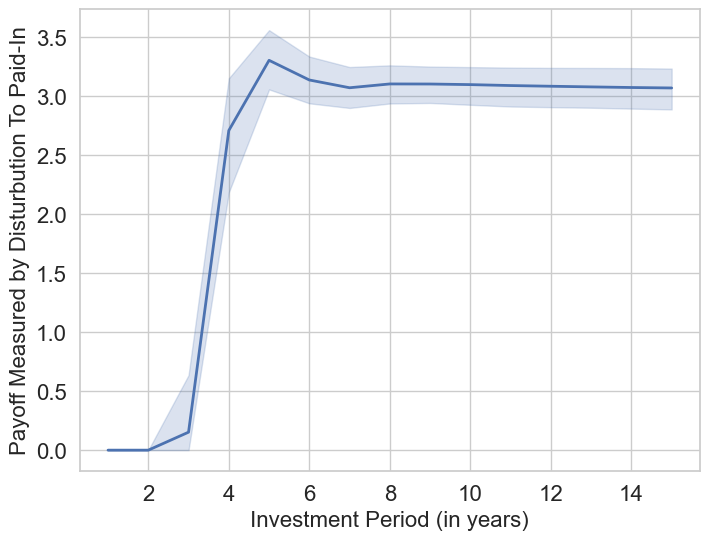

In [249]:
sns.lineplot(x='Investment Period (in years)', y='DPI Payoff', data=df_test_simple, errorbar=("pi", 80),linewidth=2)
plt.xlabel("Investment Period (in years)", fontsize=16)
plt.ylabel("Payoff Measured by Disturbution To Paid-In", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figures/DPI_investmentPeros_Medium.pdf', format='pdf', dpi=1200)


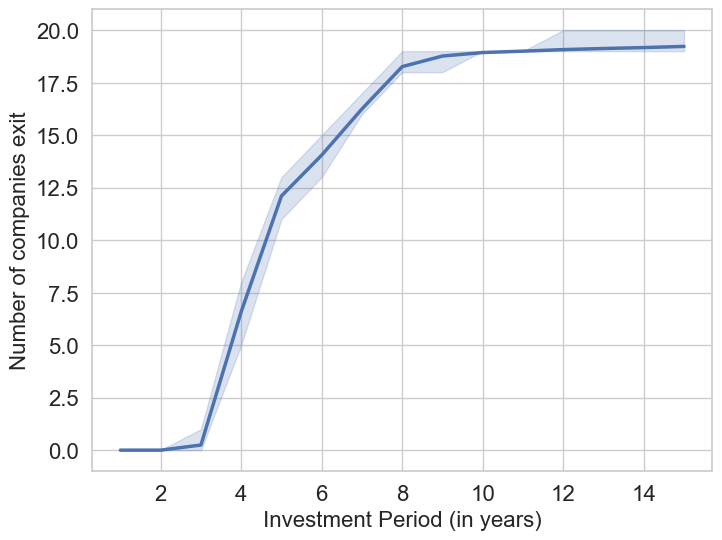

In [250]:
sns.lineplot(x='Investment Period (in years)', y='Number of companies exit', data=df_test_simple, errorbar=("pi", 80),linewidth=2.5)
plt.xlabel("Investment Period (in years)", fontsize=16)
plt.ylabel("Number of companies exit", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figures/CompanyExit_investmentPeros_Medium.pdf', format='pdf', dpi=1200)

###  Single Company Exit define by multi 

In [266]:
exit_multi = np.array([5,10,30,60])
K_test = 500
terminated_time = 15

df_payoff = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(1,terminated_time+1),K_test),
                                   'Simulation label': np.tile(np.arange(K_test),terminated_time)})
df_company_exit = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(1,terminated_time+1),K_test),
                                   'Simulation label': np.tile(np.arange(K_test),terminated_time)})
# df_investment = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(1,terminated_time+1),K_test),
                                #    'Simulation label': np.tile(np.arange(K_test),terminated_time)})
df_payoff_2 = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(1,terminated_time+1),K_test),
                                   'Simulation label': np.tile(np.arange(K_test),terminated_time)})
df_payoff_3 = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(1,terminated_time+1),K_test),
                                   'Simulation label': np.tile(np.arange(K_test),terminated_time)})
df_payoff_4 = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(1,terminated_time+1),K_test),
                                   'Simulation label': np.tile(np.arange(K_test),terminated_time)})                          

for multi in exit_multi:
    test_ARM_revised = PE_portfolio_investperiod_revise(K=K_test, Expact_exit_mutiple = multi, Expect_DPI = 10, Expect_portfolio_multi= 100,Max_investment_length= terminated_time)
    _,_,t3,t4,t5,t6,t7,t8 = test_ARM_revised.ARM_mini_investments_rounds()
    df_payoff['DPI Payoff when Single company exit multi = {}'.format(multi)] = t3.flatten()
    df_company_exit['Number of companies exit when Single company exit multi = {}'.format(multi)] = t4.flatten()
    # df_investment['Total Investment Amount when Investment Threshold = {}'.format(multi)] = t5.flatten()
    df_payoff_2['Multi Payoff when Single company exit multi = {}'.format(multi)] = t6.flatten()
    df_payoff_3['NAV Payoff when Single company exit multi = {}'.format(multi)] = t7.flatten()
    df_payoff_4['Relatively NAV Payoff when Single company exit multi = {}'.format(multi)] = t8.flatten()


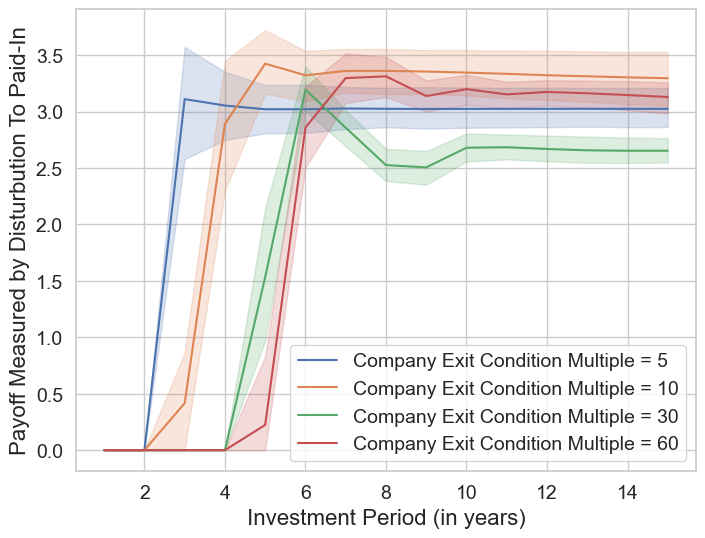

In [267]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("whitegrid")
for multi in exit_multi:
    sns.lineplot(x='Investment Period (in years)', y='DPI Payoff when Single company exit multi = {}'.format(multi), data=df_payoff, errorbar=("pi", 80), label='Company Exit Condition Multiple = {}'.format(multi))
plt.ylabel('Payoff Measured by DPI')
plt.xlabel("Investment Period (in years)", fontsize=16)
plt.ylabel("Payoff Measured by Disturbution To Paid-In", fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/DPI_investmentPeros_diff_multi.pdf', format='pdf', dpi=1200)

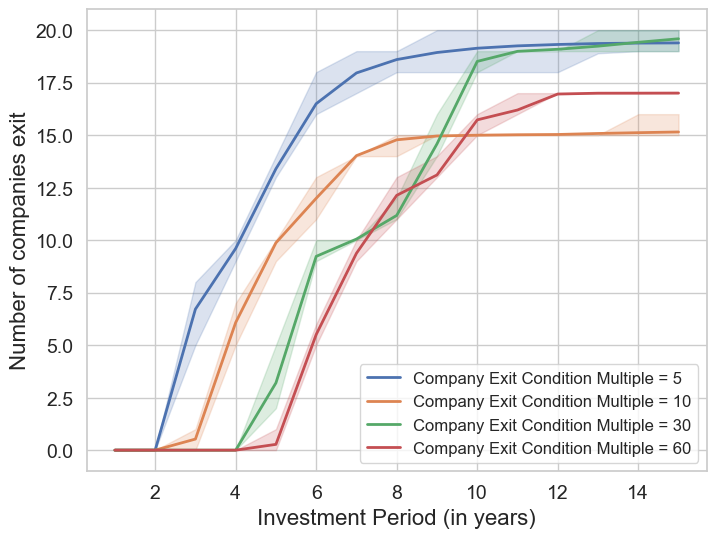

In [268]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("whitegrid")
for multi in exit_multi:
    sns.lineplot(x='Investment Period (in years)', y='Number of companies exit when Single company exit multi = {}'.format(multi), data=df_company_exit, errorbar=("pi", 80), label='Company Exit Condition Multiple = {}'.format(multi),linewidth=2)
plt.xlabel("Investment Period (in years)", fontsize=16)
plt.ylabel("Number of companies exit", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.savefig('figures/CompanyExit_investmentPeros_diff_multi.pdf', format='pdf', dpi=1200)

### Compare different exit condition

In [213]:
test_1 = PE_portfolio_investperiod_revise(K=50,invest_per_firmval= 0.35, inital_firm_value = 45, investment_condition = 1.2, Max_investment_length= 15, Expact_exit_mutiple = 10, Expect_DPI = 3,Expect_portfolio_multi=10) 
test_success,tau,T_mDPI,t_number_company_exit,t_sum_investment_matrix,t_multi,t_NAV,t_NAVdivdiIF = test_1.ARM_mini_investments_rounds()

In [214]:
_,tau_rand,t_mDPI_rand,t_company_exit_rand,_,t_muti_rand,_,t_DMPI_rand = test_1.ARM_mini_investments_rounds_randomexit()

In [216]:
K_test = 50
terminated_time = tau_rand +1

df_DPI = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(1,terminated_time+1),K_test),
                                   'Simulation label': np.tile(np.arange(K_test),terminated_time)})
df_DMPI = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(1,terminated_time+1),K_test),
                                   'Simulation label': np.tile(np.arange(K_test),terminated_time)})
df_companyexit = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(1,terminated_time+1),K_test),
                                   'Simulation label': np.tile(np.arange(K_test),terminated_time)})
df_DPI['Exit condition on Exit mutiples > 10'] = T_mDPI.flatten()[:len(t_mDPI_rand.flatten())]
df_DPI['Random Exit'] = t_mDPI_rand.flatten()
df_companyexit['Exit condition on Exit mutiples > 10'] = t_number_company_exit.flatten()[:len(t_mDPI_rand.flatten())]
df_companyexit['Random Exit'] = t_company_exit_rand.flatten()


ValueError: Length of values (400) does not match length of index (700)

In [217]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("whitegrid")
sns.lineplot(x='Investment Period (in years)', y='Exit condition on Exit mutiples > 10', data=df_DPI, errorbar=("pi", 80),label='Exit condition on mutiples')
sns.lineplot(x='Investment Period (in years)', y='Random Exit', data=df_DPI, errorbar=("pi", 80),label = 'Random exit')
plt.xlabel("Investment Period (in years)", fontsize=16)
plt.ylabel("Payoff Measured by Disturbution To Paid-In", fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/DPI_investmentPeros_diff_exit_condition.pdf', format='pdf', dpi=1200)

ValueError: Could not interpret value `Exit condition on Exit mutiples > 10` for parameter `y`

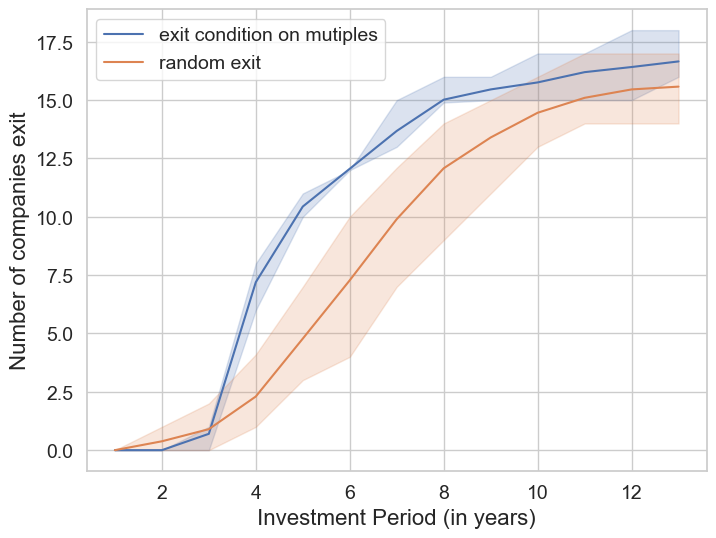

In [173]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("whitegrid")
sns.lineplot(x='Investment Period (in years)', y='Exit condition on Exit mutiples > 10', data=df_companyexit, errorbar=("pi", 80),label='exit condition on mutiples')
sns.lineplot(x='Investment Period (in years)', y='Random Exit', data=df_companyexit, errorbar=("pi", 80),label = 'random exit')
plt.ylabel('Number of companies exit', fontsize=16)
plt.xlabel("Investment Period (in years)", fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/CompanyExit_investmentPeros_diff_exit_condition.pdf', format='pdf', dpi=1200)

### Different investment condition

In [277]:
investment_threshold = np.array([1.0,1.5,2.0,2.5])
K_test = 500
terminated_time = 15

df_payoff = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(terminated_time),K_test),
                                   'Simulation label': np.tile(np.arange(K_test),terminated_time)})
df_company_exit = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(terminated_time),K_test),
                                   'Simulation label': np.tile(np.arange(K_test),terminated_time)})
df_investment = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(terminated_time),K_test),
                                   'Simulation label': np.tile(np.arange(K_test),terminated_time)})
df_payoff_2 = pd.DataFrame({'Investment Period (in years)': np.repeat(np.arange(terminated_time),K_test),
                                   'Simulation label': np.tile(np.arange(K_test),terminated_time)})

for thresh in investment_threshold:
    test_ARM_revised = PE_portfolio_investperiod_revise(K=K_test, Expact_exit_mutiple = multi, investment_condition = thresh, Expect_DPI = 15, Expect_portfolio_multi= 100,Max_investment_length= terminated_time)
    _,_,t3,t4,t5,t6,t7,t8 = test_ARM_revised.ARM_mini_investments_rounds()
    df_payoff['DPI Payoff when Investment Threshold = {}'.format(thresh)] = t3.flatten()
    df_company_exit['Number of companies exit when Investment Threshold = {}'.format(thresh)] = t4.flatten()

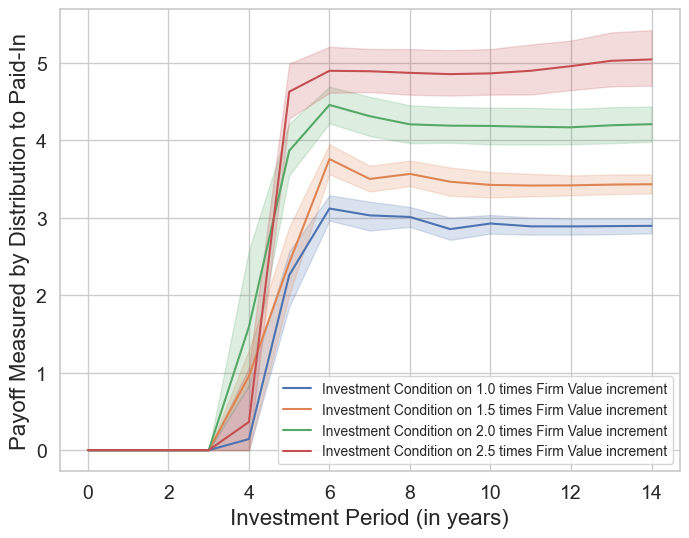

In [278]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("whitegrid")
for thresh in investment_threshold:
    sns.lineplot(x='Investment Period (in years)', y='DPI Payoff when Investment Threshold = {}'.format(thresh), data=df_payoff, errorbar=("pi", 80), label='Investment Condition on {} times Firm Value increment'.format(thresh))
plt.ylabel('Payoff Measured by Distribution to Paid-In', fontsize=16)
plt.xlabel("Investment Period (in years)", fontsize=16)
plt.legend(fontsize=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/DPI_investmentPeros_investment_condition.pdf', format='pdf', dpi=1200)

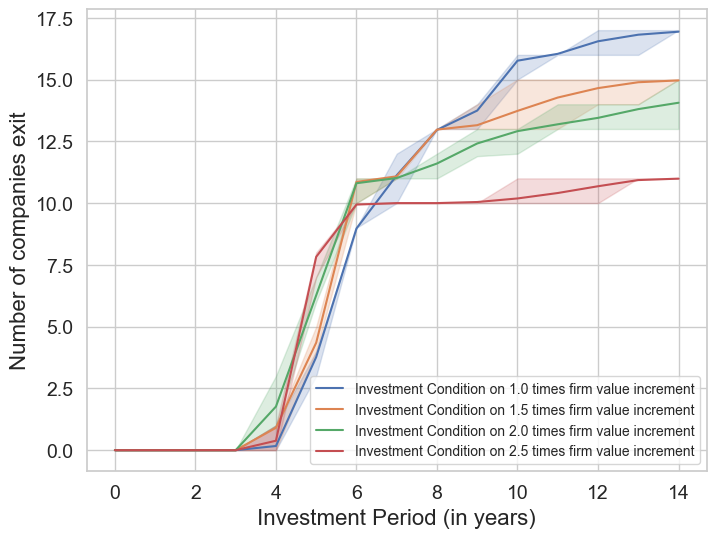

In [280]:
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("whitegrid")
for thresh in investment_threshold:
    sns.lineplot(x='Investment Period (in years)', y='Number of companies exit when Investment Threshold = {}'.format(thresh), data=df_company_exit, errorbar=("pi", 80), label='Investment Condition on {} times firm value increment'.format(thresh))
plt.ylabel('Number of companies exit', fontsize=16)
plt.xlabel("Investment Period (in years)", fontsize=16)
plt.legend(fontsize=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/CompanyExit_investmentPeros_investment_condition.pdf', format='pdf', dpi=1200)

## Model Validation

### SIAM model for one comapny

In [129]:
# revised 10.28
class selection_one_company_knowndata():
    def __init__(self, K=100, growth_rate= 3, invest_jump = 1,decrease_jump = 0, investment_amount=[30,40,50], investment_round=[1,3,4], inital_firm_value=150, Max_investment_length= 20, Expacted_net_pro_ratio=10, muti=3):
        self.K = K #number of iteration
        self.growth_rate = growth_rate
        self.invest_jump = invest_jump
        self.decrease_jump = decrease_jump
        self.inital_firm_value = inital_firm_value
        self.investment_round = investment_round
        self.investment_amount = investment_amount
        self.Max_investment_length = Max_investment_length 
        self.Expacted_net_pro_ratio = Expacted_net_pro_ratio
        self.muti = muti 
    
    def fimevalue(self,s0):
        size= 12
        dt = 1/12 
        # r,sigma = 0.02, 0.5
        r,sigma = (0.03+ self.growth_rate)/size, 0.5/size
        geo = np.cumsum(((r -  sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)
        return np.exp(geo[-1])*s0
        

    # Model exit condition on exit mutiples + jump incre + jump decrease
    def Mini_investments_rounds_muti_JD1(self):
        
        # descision variable: Company's status in the portfolio --- 0 in 1 out
        company_invest_status = np.zeros((self.Max_investment_length,self.K))
        
        # firm value
        # firm_value = np.full((self.K,self.Max_investment_length),self.inital_firm_value)
        zero_positions = [i for i, x in enumerate(self.investment_round) if x == 0]

        jump_at_0 = sum(self.investment_amount[i] for i in zero_positions) if zero_positions else 0

        if jump_at_0 != 0:
            firm_value = np.full((self.K,self.Max_investment_length),self.inital_firm_value*np.exp(self.invest_jump*jump_at_0/self.inital_firm_value))
        else:
            firm_value = np.full((self.K,self.Max_investment_length),self.inital_firm_value)
        
        
        # investment amount at time t 
        sum_investment = np.zeros(self.Max_investment_length)
        np.put(sum_investment, self.investment_round, self.investment_amount)  # Assign values at specified indices
        sum_investment_list = np.cumsum(sum_investment)

        exit_time_list = np.zeros(self.K)

        for k in range(self.K): 
            # Number of rounds of investment companies go though 
            # company_rounds = 0
            if jump_at_0 != 0:
                company_rounds = len(zero_positions)
            else:
                company_rounds = 0

            for t in range(1,self.Max_investment_length):
                
                if firm_value[k][t-1] < self.inital_firm_value * 0.01:
                    company_invest_status[t:,k] = np.full((self.Max_investment_length-t),2)
                else:
                    # Check if company is still in portfolio
                    if company_invest_status[t][k] == 0:
                        
                        # firm value : last time +/- bad
                        # Last part: For companies go through bad sceniaro firm value decrease
                        firm_value[k][t] = self.fimevalue(firm_value[k][t-1]) * np.exp(np.random.poisson(0.2*t)*(self.decrease_jump))
                        
                        # Exit the company if reach threshold
                        if (company_rounds < len(self.investment_round) -1) & (t == self.investment_round[company_rounds]):
                            firm_value[k][t] = (firm_value[k][t] + self.investment_amount[company_rounds])*np.exp(self.invest_jump*self.investment_amount[company_rounds]/firm_value[k][t])
                            company_rounds = company_rounds + 1
                                    
                        # For company still in the portfolio and need investment
                        else:
                            if (sum_investment_list[t-1] > 0) and (firm_value[k][t]/self.inital_firm_value > self.muti):
                                company_invest_status[t][k] = 1
                                exit_time_list[k] = t
                                break        
                
                exit_time_list= np.where(exit_time_list==0, np.nan, exit_time_list)
        return exit_time_list,np.nanmean(exit_time_list)
    

In [130]:
company1 = selection_one_company_knowndata(K=100,growth_rate= 2,investment_amount=[10,20,40], investment_round=[0,0,4],invest_jump= 3, decrease_jump = 0, muti= 3)
# output whether the company was successfully exit + investment amount in each round + exit firm value at each round
company1.Mini_investments_rounds_muti_JD1()

(array([3., 3., 4., 3., 3., 4., 3., 3., 4., 3., 5., 3., 3., 3., 4., 3., 3.,
        3., 4., 3., 3., 4., 3., 3., 4., 4., 4., 3., 3., 4., 3., 5., 4., 4.,
        3., 3., 4., 3., 3., 4., 3., 3., 4., 3., 3., 3., 3., 2., 3., 3., 3.,
        3., 3., 3., 3., 3., 4., 3., 4., 3., 4., 3., 3., 3., 3., 4., 4., 2.,
        3., 4., 4., 4., 3., 4., 4., 3., 5., 3., 4., 3., 3., 3., 3., 4., 3.,
        3., 3., 3., 3., 4., 4., 3., 4., 4., 3., 4., 3., 4., 4., 4.]),
 3.39)

### Valdition --- fit growth rate and other factor's influence, compare with DeTree

In [ ]:
df_delete_extreme.shape[0]

710

In [124]:
df_delete_extreme_val = df_delete_extreme.copy()

#### The bisection method to fit the growth rate for all companies

In [131]:
def find_growth_rate(df,invest_jump_rate):
    
    SIAM_cal_growth_rate = np.zeros((df.shape[0]))

    convert_float_to_int = lambda value: np.nan if np.isnan(value) else int(round(value))


    for index, row in df.iterrows():
        upper_bound = 20
        lower_bound = -20
        eplison = 0.01
        repeated_time = 50
        target_tau = row['Investment_period']
        contiu = True
        
        company_exit_round = selection_one_company_knowndata(K=repeated_time, invest_jump= invest_jump_rate, growth_rate=lower_bound, investment_amount = row['investment_amount_list'], investment_round =  row['investment_time_list'], 
                                                            inital_firm_value = row['initial_firmvalue'],
                                                            Max_investment_length = 20, Expacted_net_pro_ratio=row['payoff_DPI'],muti=row['payoff_firmvalue_muti'])
        _, tau = company_exit_round.Mini_investments_rounds_muti_JD1()
        tau = convert_float_to_int(tau)

        while tau != target_tau and ((upper_bound-lower_bound)>=eplison) and (contiu == True):

            guess_growthrate = (lower_bound + upper_bound) / 2
            company_exit_round = selection_one_company_knowndata(K=repeated_time, invest_jump= invest_jump_rate, growth_rate=guess_growthrate, investment_amount = row['investment_amount_list'], investment_round =  row['investment_time_list'], 
                                                            inital_firm_value = row['initial_firmvalue'],
                                                            Max_investment_length = 20, Expacted_net_pro_ratio=row['payoff_DPI'],muti=row['payoff_firmvalue_muti'])
            _, tau = company_exit_round.Mini_investments_rounds_muti_JD1()

            tau = convert_float_to_int(tau)

            if tau == target_tau:
                SIAM_cal_growth_rate[index] = guess_growthrate
                contiu = False
            else:
                if (tau > target_tau) or np.isnan(tau):
                    lower_bound = guess_growthrate
                else:
                    upper_bound = guess_growthrate
                    # print(guess_growthrate,tau,target_tau)
        if contiu:
            if (tau == target_tau -1) or (tau == target_tau + 1):
                SIAM_cal_growth_rate[index] = guess_growthrate
            SIAM_cal_growth_rate[index] = np.nan
        # else:
        #     SIAM_cal_growth_rate[index] = guess_growthrate
        
    df['SIAM_growth_rate_{}'.format(invest_jump_rate)] = SIAM_cal_growth_rate

    return df

#### Find Growth rate for all companies --- current only 340 avaliable

##### study why invest jump increase avability decrease

In [132]:
df_delete_extreme_val = find_growth_rate(df_delete_extreme_val,1.5)
df_delete_extreme_val = find_growth_rate(df_delete_extreme_val,1)
df_delete_extreme_val = find_growth_rate(df_delete_extreme_val,0.5)
df_delete_extreme_val = find_growth_rate(df_delete_extreme_val,0)

In [133]:
df_delete_extreme_val.iloc[:,20:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SIAM_growth_rate_1.5  346 non-null    float64
 1   SIAM_growth_rate_1    391 non-null    float64
 2   SIAM_growth_rate_0.5  456 non-null    float64
 3   SIAM_growth_rate_0    529 non-null    float64
dtypes: float64(4)
memory usage: 22.3 KB


In [ ]:
# # Define a custom "Blues" palette with darker colors
# custom_palette = sns.color_palette("Set2")  # You can adjust n_colors to control the intensity

# # Assuming df_delete_extreme_val is your DataFrame
# data_to_plot = df_delete_extreme_val.iloc[:, 20:].iloc[:, ::-1]
# # Create a histogram plot with the custom palette
# ax = data_to_plot.plot.hist(alpha=0.5, color=custom_palette)

# # Add labels and title
# plt.xlabel('X-axis Label')
# plt.ylabel('Frequency')
# legend_labels = ["Investment Period = 0", "Investment Period = 0.1", "Investment Period = 0.5", "Investment Period = 1.0"]
# ax.legend(legend_labels)

# # Show the plot
# plt.show()


##### Validation via Decision Tree Model 

In [135]:
def DecisTree_predict_RMSE(df,y_label):
    # return y_predict

    X_feature_column_name = ['initial_firmvalue','industry_encoded','start_date_diff_earliest','sum_invest_amount','Number_of_round','payoff_firmvalue_muti','exit_type']
    df_X = df[X_feature_column_name]
    df_Y = df[[y_label]].values
    df_Y_reshaped  = np.reshape(df_Y , (-1,1))

    # Standard 
    scaler = StandardScaler()
    df_X_scaler = scaler.fit_transform(df_X)

    regressor = DecisionTreeRegressor()

    # Define the hyperparameter grid for GridSearchCV
    params = {"max_depth": np.arange(1, 11)}

    # Create the GridSearchCV instance
    grid = GridSearchCV(regressor, params, scoring='neg_root_mean_squared_error', cv=5)

    # Fit the GridSearchCV on the training data
    grid.fit(df_X_scaler,df_Y_reshaped)

    # Get the best estimator from the grid search
    best_estimator = grid.best_estimator_

    # Print the test score
    # print('Best Estimator',best_estimator, ' Best Score',grid.best_score_,'for ',y_label)

    return best_estimator,grid.best_score_,df_X_scaler,df_Y_reshaped
        

The normal way euqation

In [136]:
def DTgrowthrate_SIAMinvestperiod_RMSE(df,investjump):

    best_est,_,df_X_scaler,df_Y_reshaped = DecisTree_predict_RMSE(df,'SIAM_growth_rate')
    
    regressor = DecisionTreeRegressor(max_depth=best_est.max_depth)
    df_Y_pred = cross_val_predict(regressor, df_X_scaler,df_Y_reshaped, cv=3)
    df['DT_pred_growthrate_{}'.format(0)] = df_Y_pred

    DT_SIAM_invest_period = []
    for index, row in df.iterrows():
        company1 = selection_one_company_knowndata(K=20,invest_jump = investjump, growth_rate=row['DT_pred_growthrate_{}'.format(0)],investment_amount = row['investment_amount_list'], investment_round =  row['investment_time_list'], inital_firm_value = row['initial_firmvalue'],
                                                                Max_investment_length = 20, Expacted_net_pro_ratio=row['payoff_DPI'],muti=row['payoff_firmvalue_muti'])
    # output whether the company was successfully exit + investment amount in each round + exit firm value at each round
        _,tau = company1.Mini_investments_rounds_muti_JD1()
        DT_SIAM_invest_period.append(tau)
    df['DT_SIAM_investperiod_{}'.format(investjump)] = DT_SIAM_invest_period
    df_dropna = df.dropna(axis=0)
    # r2_score(df_delete_extreme_val['DT_SIAM_investperiod'],df_delete_extreme_val['Investment_period'])
    return df, np.sqrt(mean_squared_error(df_dropna['DT_SIAM_investperiod_{}'.format(investjump)],df_dropna['Investment_period']))

The opposite way equation

In [137]:
def DTinvestperiod_SIAMgrowthrate_RMSE(df,invest_jump_rate):
    
    SIAM_cal_growth_rate = np.zeros((df.shape[0]))

    convert_float_to_int = lambda value: np.nan if np.isnan(value) else int(round(value))


    for index, row in df.iterrows():
        upper_bound = 20
        lower_bound = -20
        eplison = 0.01
        repeated_time = 50
        target_tau = row['DT_pred_investperiod_{}'.format(invest_jump_rate)] 
        contiu = True
        
        company_exit_round = selection_one_company_knowndata(K=repeated_time, invest_jump= invest_jump_rate, growth_rate=lower_bound, investment_amount = row['investment_amount_list'], investment_round =  row['investment_time_list'], 
                                                            inital_firm_value = row['initial_firmvalue'],
                                                            Max_investment_length = 20, Expacted_net_pro_ratio=row['payoff_DPI'],muti=row['payoff_firmvalue_muti'])
        _, tau = company_exit_round.Mini_investments_rounds_muti_JD1()
        tau = convert_float_to_int(tau)

        while tau != target_tau and ((upper_bound-lower_bound)>=eplison) and (contiu == True):

            if tau == (target_tau -1) or (tau == target_tau + 1):
                tau_close = True
            guess_growthrate = (lower_bound + upper_bound) / 2
            company_exit_round = selection_one_company_knowndata(K=repeated_time, invest_jump= invest_jump_rate, growth_rate=guess_growthrate, investment_amount = row['investment_amount_list'], investment_round =  row['investment_time_list'], 
                                                            inital_firm_value = row['initial_firmvalue'],
                                                            Max_investment_length = 20, Expacted_net_pro_ratio=row['payoff_DPI'],muti=row['payoff_firmvalue_muti'])
            _, tau = company_exit_round.Mini_investments_rounds_muti_JD1()

            tau = convert_float_to_int(tau)

            if tau == target_tau:
                SIAM_cal_growth_rate[index] = guess_growthrate
                contiu = False
            else:
                if (tau > target_tau) or np.isnan(tau):
                    lower_bound = guess_growthrate
                else:
                    upper_bound = guess_growthrate
                    # print(guess_growthrate,tau,target_tau)
        if contiu:
            if (tau == target_tau -1) or (tau == target_tau + 1):
                SIAM_cal_growth_rate[index] = guess_growthrate
            SIAM_cal_growth_rate[index] = np.nan
        # else:
        #     SIAM_cal_growth_rate[index] = guess_growthrate
        
    df['DTSIAM_growth_rate_{}'.format(invest_jump_rate)] = SIAM_cal_growth_rate

    df.dropna(axis = 0, inplace=True)

    return df,np.sqrt(mean_squared_error(df['DTSIAM_growth_rate_{}'.format(invest_jump_rate)],df['SIAM_growth_rate']))

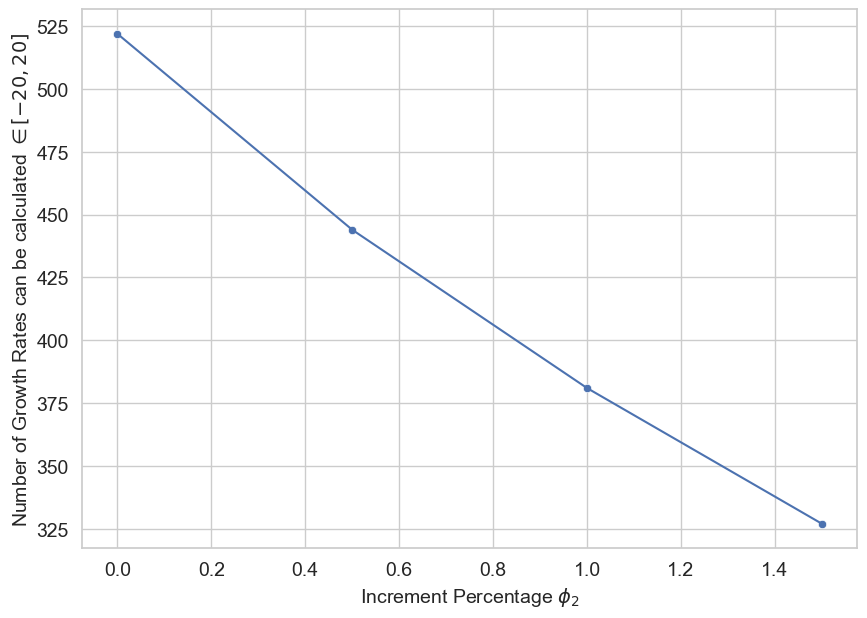

In [156]:
# Data
phi_2_values = [0, 0.5, 1, 1.5]
growth_rate_counts = [522, 444, 381, 327]

# Create a dataframe to use with seaborn

data = pd.DataFrame({'Increment Percentage (phi_2)': phi_2_values, 'Number of Growth Rates': growth_rate_counts})

# Create the bar plot using seaborn
plt.figure(figsize=(10, 7))
sns.set_style('whitegrid')
ax = sns.lineplot(x='Increment Percentage (phi_2)', y='Number of Growth Rates', data=data, palette="Set2")
ax = sns.scatterplot(x='Increment Percentage (phi_2)', y='Number of Growth Rates', data=data, palette="Set2")

# Add labels and title
plt.xlabel('Increment Percentage $\phi_2$',fontsize=14)
plt.ylabel('Number of Growth Rates can be calculated $\in [-20,20]$',fontsize=14)
# plt.title('Number of Growth Rates for Different Increment Percentages')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/invest_jump_growthrate_avali.pdf', format='pdf', dpi=1200)

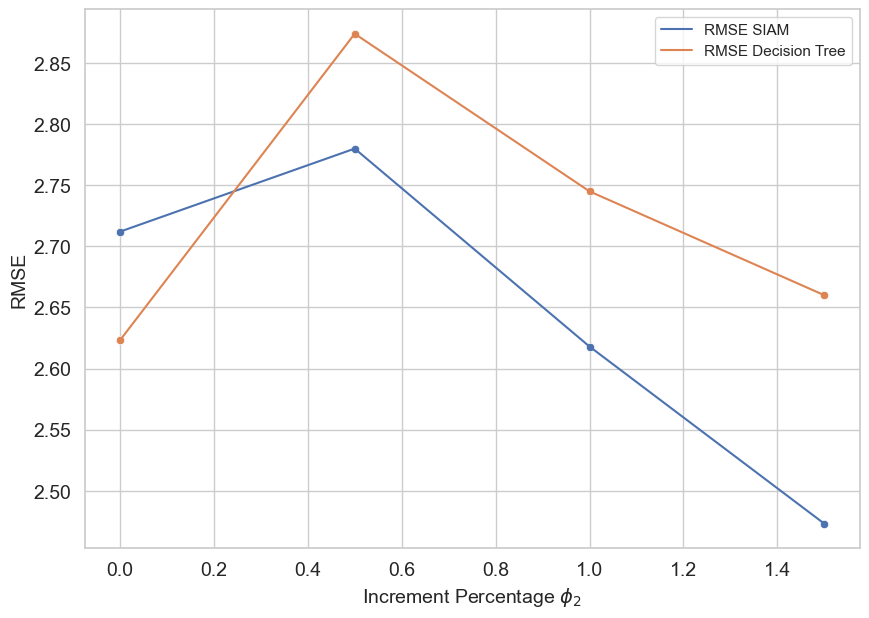

In [157]:
# Data
phi_2_values = [0, 0.5, 1, 1.5]
growth_rate_SIAM_RMSE = [2.712,2.780,2.618,2.473]
growth_rate_DescisionTree_RMSE = [2.623,2.874,2.745,2.660]
sns.set_style('whitegrid')
# Create a dataframe to use with seaborn
data = pd.DataFrame({
    'Increment Percentage (phi_2)': phi_2_values,
    'RMSE SIAM': growth_rate_SIAM_RMSE,
    'RMSE Decision Tree': growth_rate_DescisionTree_RMSE
})

# Create the bar plot using seaborn
plt.figure(figsize=(10, 7))
ax = sns.lineplot(x='Increment Percentage (phi_2)', y='RMSE SIAM', data=data, label='RMSE SIAM',palette="Set2")
ax = sns.scatterplot(x='Increment Percentage (phi_2)', y='RMSE SIAM', data=data, palette="Set2")
ax = sns.lineplot(x='Increment Percentage (phi_2)', y='RMSE Decision Tree', data=data,label='RMSE Decision Tree', palette="Set2")
ax = sns.scatterplot(x='Increment Percentage (phi_2)', y='RMSE Decision Tree', data=data, palette="Set2")

# Add labels and title
plt.xlabel('Increment Percentage $\phi_2$',fontsize=14)
plt.ylabel('RMSE',fontsize=14)
# plt.title('Number of Growth Rates for Different Increment Percentages')
# Show the plot
plt.legend()
# Add labels and title
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/invest_jump_growthrate_rmse.pdf', format='pdf', dpi=1200)


#### Compare back and normal method for validation

In [140]:
df_delete_extreme_val.describe()

,initial_firmvalue,firmvalue_first_increment,firmvalue_final_increment,investment_increment_average,sum_invest_amount,Number_of_round,Investment_period,exit_value,exit_type,payoff_DPI,payoff_firmvalue_muti,start_date_diff_earliest,investment_time_diff,industry_encoded,SIAM_growth_rate_1.5,SIAM_growth_rate_1,SIAM_growth_rate_0.5,SIAM_growth_rate_0
count,711.000000,711.000000,710.000000,711.000000,711.00000,711.000000,711.000000,710.000000,711.000000,710.000000,710.000000,711.000000,711.000000,711.000000,346.000000,391.000000,456.000000,529.000000
mean,91.069030,140.432321,589.057417,20.378018,174.53692,4.011252,8.175809,1349.879332,0.668073,8.531082,19.798433,6.867692,1.650055,49.430380,2.955118,3.205073,3.366292,3.793050
std,259.423536,804.481127,3460.263711,101.259496,670.37266,1.328936,3.636479,5363.984449,0.471236,24.741275,45.183818,3.778231,0.745125,30.967414,2.763579,2.872200,3.115515,3.205084
min,1.070000,-473.990000,-12760.000000,-58.933333,0.73000,3.000000,1.000000,0.654000,0.000000,0.009972,0.100209,0.000000,0.250000,0.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,17.700000,8.505000,-49.120500,-0.032500,32.68000,3.000000,5.000000,60.000000,0.000000,1.322121,1.934046,3.876712,1.000000,19.000000,1.250000,1.250000,1.250000,1.562500
50%,39.800000,29.370000,28.793000,5.490000,75.00000,4.000000,8.000000,206.010000,1.000000,3.369532,5.555016,6.972603,1.500000,43.000000,2.500000,2.500000,2.578125,3.125000
75%,82.875000,86.130000,267.745000,16.812500,136.12500,5.000000,10.000000,727.522500,1.000000,7.699015,17.085627,9.841096,2.000000,76.000000,3.750000,3.906250,5.000000,5.000000
max,3784.000000,13553.600000,49880.000000,2401.133333,11588.72000,12.000000,20.000000,67613.490000,1.000000,434.064081,481.839080,14.917808,5.000000,103.000000,15.000000,17.500000,19.375000,18.750000


In [141]:
useful_columns = ['initial_firmvalue','Initial_investment_date','industry_encoded','start_date_diff_earliest','sum_invest_amount','Number_of_round','exit_type','payoff_firmvalue_muti','payoff_DPI','investment_time_list','investment_amount_list','SIAM_growth_rate_1','Investment_period']

df_delete_extreme_val_1 = df_delete_extreme_val[df_delete_extreme_val['Investment_period'] <= 15][useful_columns].copy()
df_delete_extreme_val_1.dropna(axis = 0, inplace = True)
df_delete_extreme_val_1.index = range(len(df_delete_extreme_val_1))
df_delete_extreme_val_1['SIAM_growth_rate'] = df_delete_extreme_val_1['SIAM_growth_rate_1']


In [142]:
df_test_nor,rmse_invest_siamdt = DTgrowthrate_SIAMinvestperiod_RMSE(df_delete_extreme_val_1,1)
rmse_invest_siamdt

3.6252123165433385

In [143]:
_, rmse_dt_invest, _, _ = DecisTree_predict_RMSE(df_test_nor,'Investment_period')
-rmse_dt_invest

2.8657212642061287

In [144]:
# Define a range of years you're interested in (2002 to 2016 in this case)
start_year = 2010
end_year = 2016
actual_max_period = []
pred_max_period = []

# Create a dictionary of DataFrames, each for a specific year
data_by_year = {}
for year in range(start_year, end_year + 1):
    df = df_test_nor[df_test_nor['Initial_investment_date'].dt.year == year]
    actual_max_period.append(df[['Investment_period']].max().values[0])
    pred_max_period.append(df[['DT_SIAM_investperiod_1']].max().values[0])
    

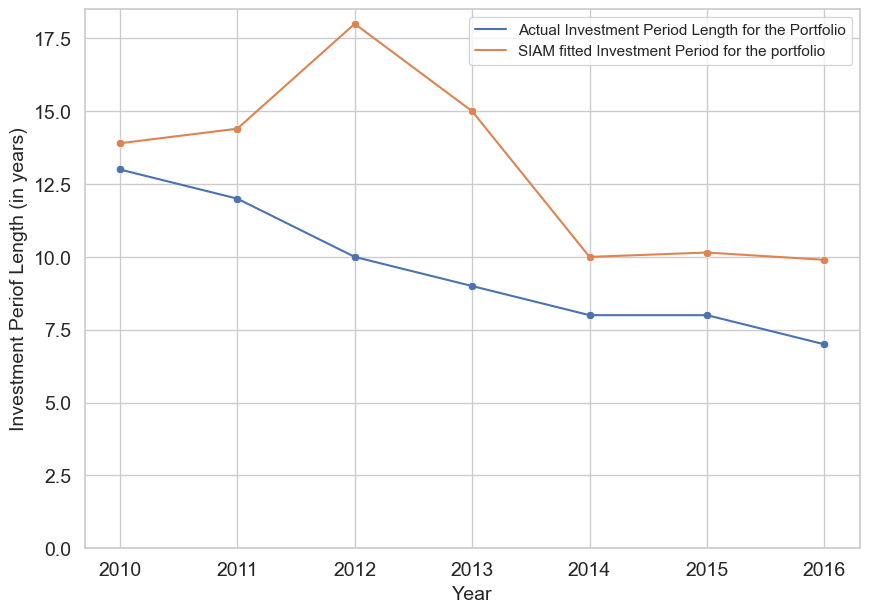

In [160]:
# Data
time_year = np.arange(2010, 2017)

sns.set_style('whitegrid')
# Create a dataframe to use with seaborn
data = pd.DataFrame({
    'Year': time_year,
    'Actual Investment Period (in years)': actual_max_period,
    'SIAM fitted Investment Period (in years)': pred_max_period
})

# Create the bar plot using seaborn
plt.figure(figsize=(10, 7))
ax = sns.lineplot(x='Year', y='Actual Investment Period (in years)', data=data, label='Actual Investment Period Length for the Portfolio',palette="Set2")
ax = sns.scatterplot(x='Year', y='Actual Investment Period (in years)', data=data, palette="Set2")
ax = sns.lineplot(x='Year', y='SIAM fitted Investment Period (in years)', data=data,label='SIAM fitted Investment Period for the portfolio', palette="Set2")
ax = sns.scatterplot(x='Year', y='SIAM fitted Investment Period (in years)', data=data, palette="Set2")

# Add labels and title
plt.xlabel('Year',fontsize=14)
plt.ylabel('Investment Periof Length (in years)',fontsize=14)
plt.ylim([0,18.5])
# Show the plot
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/portfolio_compare_actual_inevstment_period.pdf', format='pdf', dpi=1200)